# Finite element solver for the 1D wave equation

> A finite-element solver for the 1D wave equation.

In [ ]:
# | default_exp solver.wave1d_fe


We use finite elements to obtain the mass $M$ and stiffness $K$ matrices.
We use bilinear discretization for the time stepping.

$$
\begin{bmatrix} \dot{\mathbf{x}} \\ \ddot{\mathbf{x}} \end{bmatrix} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & 0 \end{bmatrix} \begin{bmatrix} \mathbf{x} \\ \dot{\mathbf{x}} \end{bmatrix} + \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix} \mathbf{f}
$$

In [ ]:
# | export

import skfem
from skfem.helpers import dot, grad
from skfem import BilinearForm, ElementLineP1, Basis
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import jax.numpy as jnp

In [ ]:
# | export

def discretize(A, step):
    """
    Jax compatible bilinear discretization from https://github.com/srush/annotated-s4
    """

    I = jnp.eye(A.shape[0])
    Ab = jnp.linalg.inv(I - (step / 2.0) * A) @ (I + (step / 2.0) * A)
    return Ab

In [ ]:
# | export

class Wave1dSolverFE:
    """
    This class solves the 1D wave equation using finite elements and state space discretization.
    """

    def __init__(
        self,
        sampling_rate: float,  # sampling rate in Hz
        final_time: float,  # final time in seconds
        length: float,  # length of the string in meters
        n_gridpoints: int,  # number of points in the string
        wave_speed: float = 1,  # wave speed in m/s
    ):
        self.sampling_rate = sampling_rate
        self.final_time = final_time
        self.length = length
        self.wave_speed = wave_speed
        self.n_gridpoints = n_gridpoints

        self.dt = 1 / self.sampling_rate
        self.timesteps = np.arange(0, self.final_time, self.dt)
        self.grid = np.linspace(0, self.length, self.n_gridpoints)
        self.dx = self.grid[1] - self.grid[0]
        self.pde_order_time_derivatives = 2

        print(f"dx: {self.dx} in meters")
        print(f"dt: {self.dt} in seconds")
        print(f"number of points (n_gridpoints): {self.grid.shape}")
        print(f"time in samples (nt): {self.timesteps.shape}")

        # set constants
        rho = 1
        k = self.wave_speed**2 * rho

        # assemble the mass and stiffness matrices
        @BilinearForm
        def mass(u, v, w):
            return rho * u * v

        @BilinearForm
        def laplace(u, v, _):
            return k * dot(grad(u), grad(v))

        mesh = skfem.MeshLine(np.linspace(0, 1, n_gridpoints))
        element = ElementLineP1()
        basis = Basis(mesh, element)

        K = skfem.asm(laplace, basis)
        M = skfem.asm(mass, basis)
        K, M, _, _ = skfem.condense(K, M, D=mesh.boundary_nodes())

        # convert to dense matrices
        # and get -inv(M) @ K
        L = -np.linalg.inv(M.todense()) @ K.todense()

        # get the state transition matrix
        I = np.eye(L.shape[0])
        zeros = np.zeros_like(L)
        A = np.block([[zeros, I], [L, zeros]])

        # get the discrete state transition matrix
        self.A_d = discretize(A, self.dt)

    def solve(
        self,
        u0: np.ndarray,  # initial position
        v0: np.ndarray,  # initial velocity
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:  # Returns time, position, velocity

        gridpoints_no_boundary = self.n_gridpoints - 2
        h = np.concatenate([u0[1:-1], v0[1:-1]])[..., None]
        u = np.zeros((self.timesteps.shape[0], self.n_gridpoints))
        v = np.zeros_like(u)
        for idx, _ in enumerate(self.timesteps):
            h = self.A_d @ h
            u[idx, 1:-1] = h[:gridpoints_no_boundary].squeeze()
            v[idx, 1:-1] = h[gridpoints_no_boundary:].squeeze()

        return self.timesteps, u, v

Test

In [ ]:
from physmodjax.solver.generator import Gaussian

In [ ]:
n_gridpoints = 200
solver = Wave1dSolverFE(
    sampling_rate=2000,
    final_time=1,
    length=1,
    n_gridpoints=n_gridpoints,
    wave_speed=10,
)

u0 = Gaussian(num_points=n_gridpoints)()
v0 = np.zeros_like(u0)

t, u, v = solver.solve(u0, v0)


dx: 0.005025125628140704 in meters
dt: 0.0005 in seconds
number of points (n_gridpoints): (200,)
time in samples (nt): (2000,)


[<matplotlib.lines.Line2D>]

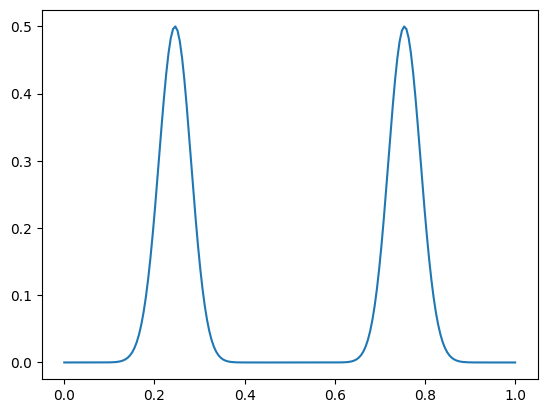

In [ ]:
plt.plot(solver.grid, u[50], label="initial")

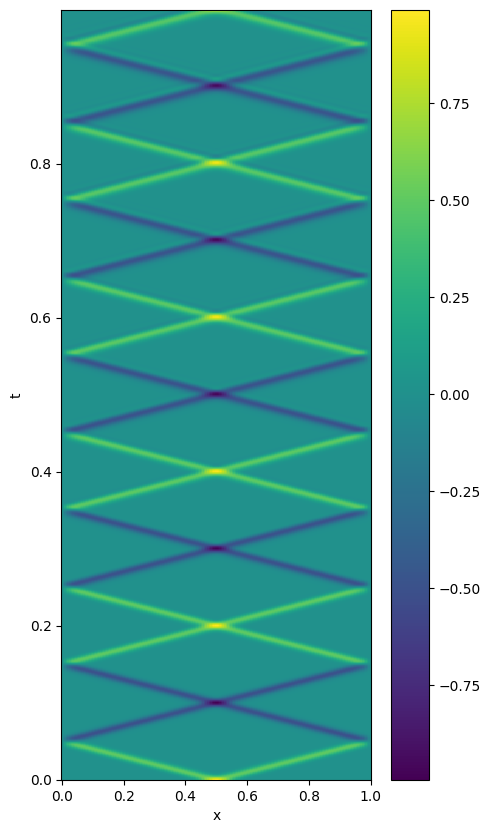

In [ ]:
# | eval : false

# show the solution viewed from above
plt.figure(figsize=(5, 10))
plt.pcolormesh(solver.grid, t, u)
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar()
plt.show()
